# Estimating travel time 

This notebooks estimates travel time within the transmilenio system. For this purpose, we use the lastest GTFSs information from Bogota, available here: http://transitfeeds.com/p/simur-bogota/973

### General process 

As many BRT system, Transmilenio services are not requeired to stop at all stations, in fact, the infraestrucute and the system allows for certain services to stop at predifined stops by design. To estimate a travel time, we will transform the the gtfs data into a transit netwrok using UrbanAccess python package. The transit netwrok will have stations as nodes, and the links will form when two stations are connected by one route. It is possible that two pair of nodes have multiple links. The weight of each link is the schedule travel time. 

Finally, we will use networkX, another python package, to calculate the shortest path lenght between two stations. The lenght of the path will be the estimates/shcedule travel time

In [1]:
import pandas as pd 
import numpy as np
import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network
import matplotlib.pyplot as plt
import re
import os; os.chdir('../..')
import difflib
%matplotlib inline

In [21]:
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [4]:
stations = pd.read_csv( os.getcwd() +'/08_Results/helper_tables/stations_w_strata')
path = '/Users/juandavidcaicedocastro/TM_datos/gtfs-2'

## Loading GTFS

We load GFTS data using UrbanAcess library. 

In [11]:
loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(path)

GTFS text file header whitespace check completed. Took 1.31 seconds
--------------------------------
Processing GTFS feed: gtfs-2
GTFS feed: gtfs-2, calendar_dates uses the same service_id across multiple agency_ids. This feed calendar_dates table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: gtfs-2, calendar uses the same service_id across multiple agency_ids. This feed calendar table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: gtfs-2, stops uses the same stop_id across multiple agency_ids. This feed stops table will be modified from its original format to provide stop_ids for each agency using a one to many join
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 31.14 seconds
Unique GTFS feed id operation co

In [12]:
loaded_feeds.stops.unique_agency_id.unique()

array(['transmilenio-urbana', 'transmilenio-alimentadores',
       'transmilenio-complementaria', 'transmilenio-especial',
       'transmilenio-dual', 'transmilenio-troncal'], dtype=object)

The GTFSs data contains the entire public transit system in Bogota. BRT is only "transmilenio-troncal". So, let's filter out the other agencies. 

In [13]:
loaded_feeds.stops = loaded_feeds.stops[loaded_feeds.stops.unique_agency_id == 'transmilenio-troncal']

In [15]:
loaded_feeds.stops.head(10)

,stop_id,unique_agency_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,wheelchair_boarding,unique_feed_id,route_type
11201,991141,transmilenio-troncal,B002,Alcala C - 2 o 5,NaN,4.721598,-74.051421,NaN,1.0,gtfs-2_1,3
11212,991142,transmilenio-troncal,B003,Alcala B - 1,NaN,4.721128,-74.051512,NaN,1.0,gtfs-2_1,3
11214,991143,transmilenio-troncal,B004,Alcala B - 2 o 5,NaN,4.720956,-74.051521,NaN,1.0,gtfs-2_1,3
11216,991144,transmilenio-troncal,B005,Alcala A - 1,NaN,4.720450,-74.051603,NaN,1.0,gtfs-2_1,3
11217,991145,transmilenio-troncal,B006,Alcala A - 2 o 5,NaN,4.720278,-74.051640,NaN,1.0,gtfs-2_1,3
11218,991147,transmilenio-troncal,B008,Alcala A - 4 o 6,NaN,4.720594,-74.051504,NaN,1.0,gtfs-2_1,3
11224,991149,transmilenio-troncal,B010,Alcala B - 4 o 6,NaN,4.721263,-74.051413,NaN,1.0,gtfs-2_1,3
11232,991151,transmilenio-troncal,B012,Alcala C - 4 o 6,NaN,4.721906,-74.051304,NaN,1.0,gtfs-2_1,3
11235,991152,transmilenio-troncal,B013,C.C. Santafe A - 3,NaN,4.763170,-74.044296,NaN,1.0,gtfs-2_1,3
11236,991153,transmilenio-troncal,B014,C.C. Santafe A - 4 o 6,NaN,4.763342,-74.044278,NaN,1.0,gtfs-2_1,3


Unfortunatelly, the stop ID correspond to a door in a station, which means that one station can have multiple IDs. To solve this problem, we will group the stop IDs that belong to the same BRT stop and assign a new ID. Additionally, the new ID should be replace in the "stops_times" table. 

As the table seems to have no easy way to group stops, I will use the location (lon, lat) of the station in my stations data, and create a buffer of 200 meters. The stop ids within that buffer will be assinged to the station of the buffer. 

In [24]:
#loading stations in geopandas (TM database)
stations_gpd = gpd.GeoDataFrame(stations, 
                                geometry = gpd.points_from_xy(stations.longitud, stations.latitud))

#assign projection (regular coordinate system)
stations_gpd.crs = {'init':'EPSG:4326'}
stations_gpd.to_crs(epsg=3310, inplace = True)

#Loading stations stops (GTFS files)
gtfs_gpd = gpd.GeoDataFrame(loaded_feeds.stops, 
                         geometry = gpd.points_from_xy(loaded_feeds.stops.stop_lon, 
                                                       loaded_feeds.stops.stop_lat))
gtfs_gpd.crs = {'init':'EPSG:4326'}
gtfs_gpd.to_crs(epsg=3310, inplace = True)

#creating buffer around stations 
stations_gpd['buffer'] = stations_gpd.buffer(200)
stations_gpd = gpd.GeoDataFrame(stations_gpd, geometry = 'buffer')

#spatial join 
merged = gpd.sjoin(gtfs_gpd, stations_gpd, how = "left", op='intersects', )
merged[['stop_name', 'nombreestacion']].to_csv('check_stations.csv')
merged.head()

,stop_id,unique_agency_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,wheelchair_boarding,unique_feed_id,route_type,geometry_left,index_right,idestacion,recaudoestacion,nombreestacion,ESTRATO,latitud,longitud,geometry_right
11201,991141,transmilenio-troncal,B002,Alcala C - 2 o 5,NaN,4.721598,-74.051421,NaN,1.0,gtfs-2_1,3,POINT (5524236.778 -2179071.206),133.0,136.0,2200.0,Alcal?(02200),3.0,4.72085,-74.0515,POINT (5524262.279 -2179140.724)
11212,991142,transmilenio-troncal,B003,Alcala B - 1,NaN,4.721128,-74.051512,NaN,1.0,gtfs-2_1,3,POINT (5524248.221 -2179117.313),133.0,136.0,2200.0,Alcal?(02200),3.0,4.72085,-74.0515,POINT (5524262.279 -2179140.724)
11214,991143,transmilenio-troncal,B004,Alcala B - 2 o 5,NaN,4.720956,-74.051521,NaN,1.0,gtfs-2_1,3,POINT (5524255.052 -2179132.768),133.0,136.0,2200.0,Alcal?(02200),3.0,4.72085,-74.0515,POINT (5524262.279 -2179140.724)
11216,991144,transmilenio-troncal,B005,Alcala A - 1,NaN,4.720450,-74.051603,NaN,1.0,gtfs-2_1,3,POINT (5524269.141 -2179181.494),133.0,136.0,2200.0,Alcal?(02200),3.0,4.72085,-74.0515,POINT (5524262.279 -2179140.724)
11217,991145,transmilenio-troncal,B006,Alcala A - 2 o 5,NaN,4.720278,-74.051640,NaN,1.0,gtfs-2_1,3,POINT (5524272.976 -2179198.523),133.0,136.0,2200.0,Alcal?(02200),3.0,4.72085,-74.0515,POINT (5524262.279 -2179140.724)


It seems that the spatial join has worked. The 'stop_name' and 'nombreestacion' seem to be similar. While most of the stops have been assinged to a station, there are some missing stations. To make sure there is a perfect match, I have manually verified each match, and change or match a missing station to a stop. 

In [26]:
#Getting final tabel with the corresponding corresponding station name 
#both in TM and GTFS files. 
GTFS_TM_stations = pd.read_csv(os.getcwd() +'/08_Results/helper_tables/GTFS_tm_stations.csv')

In [28]:
final_relation = GTFS_TM_stations.merge(loaded_feeds.stops[['stop_id','stop_name']], how = 'left', on = 'stop_name').\
merge(stations[['nombreestacion', 'recaudoestacion']],
      how = 'left', on = 'nombreestacion')

In [31]:
final_relation.head()
#The corresponding stop_id to a "recaudoestacion" id. 

,Stop ID,stop_name,nombreestacion,stop_id,recaudoestacion
0,11201,Alcala C - 2 o 5,Alcal?(02200),991141,2200
1,11212,Alcala B - 1,Alcal?(02200),991142,2200
2,11214,Alcala B - 2 o 5,Alcal?(02200),991143,2200
3,11216,Alcala A - 1,Alcal?(02200),991144,2200
4,11217,Alcala A - 2 o 5,Alcal?(02200),991145,2200


In [35]:
stations_replace_dict = final_relation.groupby('stop_id')\
                        ['recaudoestacion'].apply(lambda g: g.values[0]).to_dict()

loaded_feeds.stops.stop_id.replace(stations_replace_dict, inplace = True)

In [40]:
#Checking replace worked ok >> YES. 
loaded_feeds.stops.drop_duplicates(subset = 'stop_id', inplace = True)
loaded_feeds.stops.head(3)

,stop_id,unique_agency_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,wheelchair_boarding,unique_feed_id,route_type,geometry
11201,2200,transmilenio-troncal,B002,Alcala C - 2 o 5,NaN,4.721598,-74.051421,NaN,1.0,gtfs-2_1,3,POINT (5524236.778 -2179071.206)
11235,2001,transmilenio-troncal,B013,C.C. Santafe A - 3,NaN,4.763170,-74.044296,NaN,1.0,gtfs-2_1,3,POINT (5523124.810 -2175047.180)
11243,2303,transmilenio-troncal,B017,Calle 85 C - 1,NaN,4.673767,-74.059438,NaN,1.0,gtfs-2_1,3,POINT (5525534.942 -2183689.424)


Replace stop ID in the "stops_time" table.

In [41]:
loaded_feeds.stop_times = loaded_feeds.stop_times[loaded_feeds.stop_times.unique_agency_id == 'transmilenio-troncal']

In [43]:
loaded_feeds.stop_times.stop_id.replace(stations_replace_dict, inplace = True)
loaded_feeds.stop_times.stop_id = loaded_feeds.stop_times.stop_id.astype(str)
loaded_feeds.stops.stop_id = loaded_feeds.stops.stop_id.astype(str)

## Create Weighted public transit Network 
### Nodes and link tables

For now, we will estimate the travel time for the morning peak. The results will be usefull for trips starting on working days, from 7a.m to 10.am. The result of this step is to get two tables of the netwrok 1) Nodes table, and 2) Links table.

In [44]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
15 service_ids were extracted from calendar
113,712 trip(s) 95.99 percent of 118,462 total trip records were found in calendar for GTFS feed(s): ['gtfs-2']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
113,712 of 118,462 total trips were extracted representing calendar day: monday. Took 0.27 seconds
There are no departure time records missing from trips following monday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 2.73 seconds
Stop times from 07:00:00 to 10:00:00 successfully sel

In [45]:
urbanaccess_net = ua.network.ua_network

In [48]:
urbanaccess_net.transit_edges.head()

,node_id_from,node_id_to,weight,unique_agency_id,unique_trip_id,sequence,id,route_type,unique_route_id,net_type
0,8000_transmilenio-troncal,8001_transmilenio-troncal,1.600000,transmilenio-troncal,TR_102_100_TM_transmilenio-troncal,1,TR_102_100_TM_transmilenio-troncal_1,3,99102_transmilenio-troncal,transit
1,8001_transmilenio-troncal,9004_transmilenio-troncal,2.666667,transmilenio-troncal,TR_102_100_TM_transmilenio-troncal,2,TR_102_100_TM_transmilenio-troncal_2,3,99102_transmilenio-troncal,transit
2,9004_transmilenio-troncal,9100_transmilenio-troncal,1.733333,transmilenio-troncal,TR_102_100_TM_transmilenio-troncal,3,TR_102_100_TM_transmilenio-troncal_3,3,99102_transmilenio-troncal,transit
3,9100_transmilenio-troncal,9103_transmilenio-troncal,2.966667,transmilenio-troncal,TR_102_100_TM_transmilenio-troncal,4,TR_102_100_TM_transmilenio-troncal_4,3,99102_transmilenio-troncal,transit
4,9103_transmilenio-troncal,9105_transmilenio-troncal,2.100000,transmilenio-troncal,TR_102_100_TM_transmilenio-troncal,5,TR_102_100_TM_transmilenio-troncal_5,3,99102_transmilenio-troncal,transit


In [49]:
urbanaccess_net.transit_nodes.head()

,x,y,unique_agency_id,route_type,stop_id,stop_name,stop_code,wheelchair_boarding,net_type
node_id,,,,,,,,,
2200_transmilenio-troncal,-74.051421,4.721598,transmilenio-troncal,3,2200,Alcala C - 2 o 5,B002,1.0,transit
2001_transmilenio-troncal,-74.044296,4.763170,transmilenio-troncal,3,2001,C.C. Santafe A - 3,B013,1.0,transit
2303_transmilenio-troncal,-74.059438,4.673767,transmilenio-troncal,3,2303,Calle 85 C - 1,B017,1.0,transit
2300_transmilenio-troncal,-74.057638,4.684538,transmilenio-troncal,3,2300,Calle 100 C - 1,B029,1.0,transit
2205_transmilenio-troncal,-74.055948,4.694414,transmilenio-troncal,3,2205,Calle 106 B - 1,B041,1.0,transit


Figure created. Took 5.77 seconds


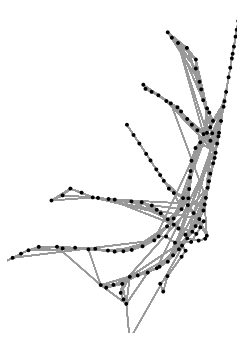

In [52]:
ua.plot.plot_net(nodes=urbanaccess_net.transit_nodes,
                 edges=urbanaccess_net.transit_edges);

## Building the Network and estimating trave time

In [70]:
import networkx as nx
import pandana as pdna

In [71]:
#Creating the graph
G=nx.Graph()

In [72]:
#Adding nodes 
G.add_nodes_from(urbanaccess_net.transit_nodes.index)

#Adding edges and weights
for x in range(len(urbanaccess_net.transit_edges)):
    G.add_edge(urbanaccess_net.transit_edges['node_id_from'][x],
           urbanaccess_net.transit_edges['node_id_to'][x],
           weight = urbanaccess_net.transit_edges['weight'][x])

In [73]:
#Experimenting
nx.shortest_path_length(G, source = '8000_transmilenio-troncal', target = '9105_transmilenio-troncal',
                       weight = 'weight')

9.183333333333334

The travel time between station 8000 and 9105 is 9.183 minutes, wich is a plausible travel time for the two stations.

TO DO 
- Make a function that take as input the station ID and returns travel time 
- Build the weighted travel time for different times of the day. 
- Estimate travel time for home-work and work-home trip